In [1]:
# unsupervised greedy layer-wise pretraining for blobs classification problem
from sklearn.datasets.samples_generator import make_blobs
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from keras.utils import to_categorical
from matplotlib import pyplot

Using TensorFlow backend.


In [8]:
# prepare the dataset
def prepare_data():
    # generate 2d classification dataset
    X, Y = make_blobs(n_samples=1000, centers=3, n_features=2,
                     cluster_std=2, random_state=2)
    # one hot encode output variable
    Y = to_categorical(Y)
    # split into train and test
    n_train = 500
    trainX, testX = X[:n_train, :], X[n_train:, :]
    trainY, testY = Y[:n_train], Y[n_train:]
    return trainX, testX, trainY, testY

In [9]:
# define, fit and evaluate the base autoencoder
def base_autoencoder(trainX, testX):
    # define model
    model = Sequential()
    model.add(Dense(10, input_dim=2, activation='relu',
                   kernel_initializer='he_uniform'))
    model.add(Dense(2, activation='linear'))
    # compile model
    model.compile(loss='mse', optimizer=SGD(lr=0.01, momentum=0.9))
    # fit model
    model.fit(trainX, trainX, epochs=100, verbose=0)
    # evaluate reconstruction loss
    train_mse = model.evaluate(trainX, trainX, verbose=0)
    test_mse = model.evaluate(testX, testX, verbose=0)
    print('> reconstruction error train=%.3f, test=%.3f' % (train_mse, test_mse))
    return model

In [15]:
# evaluate the autoencoder as a classifier
def evaluate_autoencoder_as_classifier(model, trainX, trainY, testX, testY):
    # remember the current output layer
    output_layer = model.layers[-1]
    # remove the output layer
    model.pop()
    # mark all remaining layers as non-trainable
    for layer in model.layers:
        layer.trainable = False
    # add new output layer
    model.add(Dense(3, activation='softmax'))
    # compile model
    model.compile(loss='categorical_crossentropy',
                 optimizer=SGD(lr=0.01, momentum=0.9), metrics=['acc'])
    # fit model
    model.fit(trainX, trainY, epochs=100, verbose=0)
    # evaluate model
    _, train_acc = model.evaluate(trainX, trainY, verbose=0)
    _, test_acc = model.evaluate(testX, testY, verbose=0)
    # put the model back together
    model.pop()
    model.add(output_layer)
    model.compile(loss='mse', optimizer=SGD(lr=0.01, momentum=0.9))
    return train_acc, test_acc

In [16]:
# add one new layer and re-train only the new layer
def add_layer_to_autoencoder(model, trainX, testX):
    # remember the current output layer
    output_layer = model.layers[-1]
    # remove the output layer
    model.pop()
    # mark all remaining layers as non-trainable
    for layer in model.layers:
        layer.trainable = False
    model.add(Dense(10, activation='relu', kernel_initializer='he_uniform'))
    # re-add the output layer
    model.add(output_layer)
    # fit model
    model.fit(trainX, trainX, epochs=100, verbose=0)
    # evaluate reconstruction loss
    train_mse = model.evaluate(trainX, trainX, verbose=0)
    test_mse = model.evaluate(testX, testX, verbose=0)
    print('> reconstruction error train=%.3f, test=%.3f' % (train_mse, test_mse))

In [17]:
# prepare data
trainX, testX, trainY, testY = prepare_data()

In [18]:
# get the base autoencoder
model = base_autoencoder(trainX, testX)

> reconstruction error train=0.001, test=0.001


In [19]:
# evaluate the base model
scores = dict()
train_acc, test_acc = evaluate_autoencoder_as_classifier(model, trainX, trainY, testX, testY)

W1221 06:17:09.735602  6576 deprecation.py:323] From C:\Users\Lenovo\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [20]:
len(model.layers)

2

In [21]:
train_acc

0.8240000009536743

In [22]:
test_acc

0.8400000009536743

In [23]:
scores[len(model.layers)] = (train_acc, test_acc)

In [24]:
# add layers and evaluate the updated model
n_layers = 5
for _ in range(n_layers):
    # add layer
    add_layer_to_autoencoder(model, trainX, testX)
    # evaluate model
    train_acc, test_acc = evaluate_autoencoder_as_classifier(model, trainX, trainY, testX, testY)
    print('> classifier accuracy layers=%d, train=%.3f, test=%.3f' % (len(model.layers), train_acc, test_acc))
    # store scores for plotting
    scores[len(model.layers)] = (train_acc, test_acc)

> reconstruction error train=0.001, test=0.003
> classifier accuracy layers=3, train=0.832, test=0.832
> reconstruction error train=0.001, test=0.004
> classifier accuracy layers=4, train=0.812, test=0.842
> reconstruction error train=0.010, test=0.032
> classifier accuracy layers=5, train=0.826, test=0.834
> reconstruction error train=0.009, test=0.026
> classifier accuracy layers=6, train=0.794, test=0.824
> reconstruction error train=10.410, test=10.657
> classifier accuracy layers=7, train=0.342, test=0.326


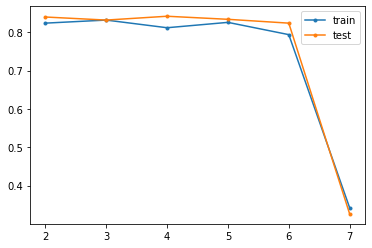

In [25]:
# plot number of added layers vs accuracy
keys = list(scores.keys())
pyplot.plot(keys, [scores[k][0] for k in keys], label='train', marker='.')
pyplot.plot(keys, [scores[k][1] for k in keys], label='test', marker='.')
pyplot.legend()
pyplot.show()